**Features a ser implementadas, por enquanto**

- Área do Polígono do receptor
- Área do Polígono do transmissor
- Quantas áreas de domínio adversária a bola do passe irá passar
- Ângulo _alpha_
- Média das distâncias mais próximas entre o receptor e as fronteiras adversárias
- Média das distâncias mais próximas entre o transmissor e as fronteiras adversárias
- Menor das distâncias mais próximas entre o transmissor e as fronteiras adversárias
- Menor das distâncias mais próximas entre o receptor e as fronteiras adversárias
- Proporção da área de regiões adversárias / amigas na faixa de possíveis passes definidos por _alpha_



In [28]:
#!pip install matplotsoccer

In [29]:
import numpy as np
import pandas as pd
import math
#import matplotsoccer
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
import scipy.spatial
from shapely.geometry import Polygon, Point, LineString
from shapely.geometry import box as Box
from shapely.plotting import plot_polygon, plot_line, plot_points

In [30]:
interception_events = pd.read_csv("interception_events.csv", index_col=0).reset_index(drop=True)
interception_events.head()

,game_id,game_event_id,possession_event_type,formatted_game_clock,start_time,end_time,duration,inserted_at,updated_at,start_frame,...,21_vy,21_vtot,21_ax,21_ay,21_atot,home_ball,ball_visibility,ball_x,ball_y,ball_z
0,4438,4435777,PA,00:00,148.300,148.300,0.0,2022-08-06 17:07:20,2022-08-07 01:31:28,4389,...,-0.75,1.060660,0.000000e+00,0.000000e+00,0.000000e+00,0.0,ESTIMATED,-2.135,1.725,0.30
1,4438,4435792,PA,00:02,151.233,151.233,0.0,2022-08-06 17:08:25,2022-08-07 01:31:28,4477,...,-0.33,0.632851,-1.598721e-12,-9.000000e-01,9.000000e-01,0.0,VISIBLE,-21.122,3.604,0.00
2,4438,4435795,PA,00:07,155.667,155.667,0.0,2022-08-06 17:08:39,2022-08-07 01:31:28,4610,...,-1.92,3.003748,1.800000e+00,0.000000e+00,1.800000e+00,0.0,VISIBLE,-8.428,-27.775,0.58
3,4438,4435805,PA,00:19,167.633,167.633,0.0,2022-08-06 17:09:04,2022-08-07 01:31:28,4969,...,0.39,0.926121,1.800000e+00,-7.993606e-13,1.800000e+00,1.0,ESTIMATED,48.219,1.006,0.82
4,4438,4435817,PA,00:21,170.033,170.033,0.0,2022-08-06 17:09:34,2022-08-07 01:31:28,5041,...,0.45,1.114854,1.598721e-12,0.000000e+00,1.598721e-12,1.0,VISIBLE,46.345,-12.923,0.00


## Montando voronoi limitado

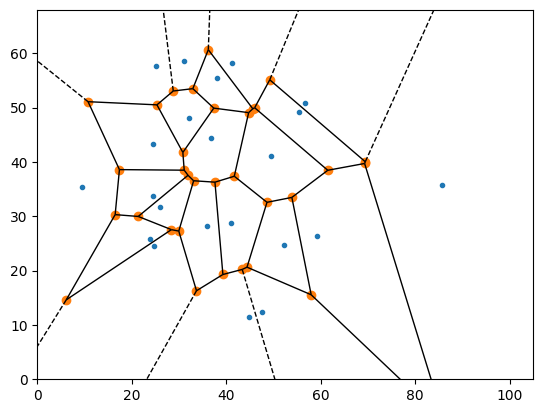

In [31]:
# Plotando um diagrama de voronoi aleatório
from scipy.spatial import Voronoi, voronoi_plot_2d

#instance_index = np.random.randint(0, len(interception_events))
instance_index = 2771

row = interception_events.loc[instance_index, :]

cols_x = [str(i)+"_x" for i in range(22)]
cols_y = [str(i)+"_y" for i in range(22)]

points = np.column_stack([(row[cols_x] + 52.5).values, (row[cols_y] + 34).values])

vor = Voronoi(points)

fig = voronoi_plot_2d(vor)
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.show()

In [32]:
#https://github.com/rougier/spatial-computation/blob/master/voronoi.py

def in_box(points, bbox):
    return np.logical_and(
        np.logical_and(bbox[0] <= points[:, 0], points[:, 0] <= bbox[1]),
        np.logical_and(bbox[2] <= points[:, 1], points[:, 1] <= bbox[3]))

def voronoi(points, bbox):
    # See http://stackoverflow.com/questions/28665491/...
    #   ...getting-a-bounded-polygon-coordinates-from-voronoi-cells
    # See also https://gist.github.com/pv/8036995

    # Select points inside the bounding box
    i = in_box(points, bbox)

    # Mirror points
    points_center = points[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bbox[0] - (points_left[:, 0] - bbox[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bbox[1] + (bbox[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bbox[2] - (points_down[:, 1] - bbox[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bbox[3] + (bbox[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left, points_right, axis=0),
                                 np.append(points_down, points_up, axis=0),
                                 axis=0), axis=0)
    # Compute Voronoi
    vor = scipy.spatial.Voronoi(points)

    # Filter regions
    epsilon = 0.1
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bbox[0]-epsilon <= x <= bbox[1]+epsilon and
                       bbox[2]-epsilon <= y <= bbox[3]+epsilon):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor

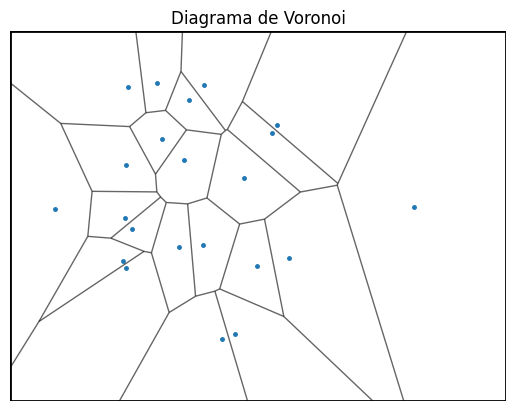

In [80]:
bounding_box = [-0.5, 105.5, -0.5, 68.5]
x = voronoi(points, bounding_box)
fig = voronoi_plot_2d(x, show_vertices=False, line_colors='k', line_width=1, line_alpha=0.6, point_size=5)
#Plot a rectangle
plt.title("Diagrama de Voronoi")
plt.plot([0, 105, 105, 0, 0], [0, 0, 68, 68, 0], 'k-', lw=2)
plt.axis('off')
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.show()

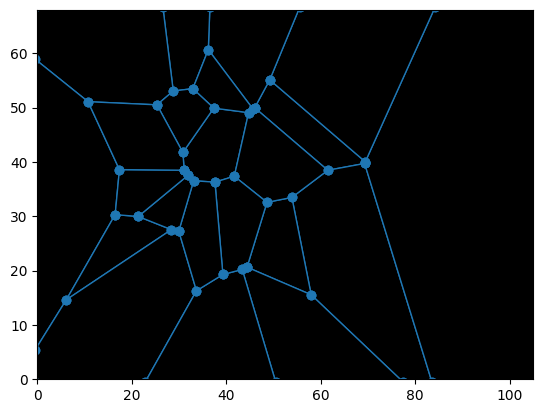

In [34]:
fig,ax = plt.subplots()

polygons = []
for region in x.filtered_regions:
  polygons.append(Polygon(x.vertices[region]))

for region in polygons:
  #print(new_vertices[region])
  plot_polygon(region, ax=ax, facecolor='k', linewidth=1)

plt.xlim(0, 105)
plt.ylim(0, 68)
plt.show()

## Features

### Area

In [35]:
areas = []
controle = [-1]*len(x.filtered_points)
for i, player in enumerate(x.filtered_points):
  for j,region in enumerate(polygons):
    player = Point(player)
    if controle[i] == -1 and region.contains(player):
      aux = Polygon(region)
      areas += [aux.area]
      controle[i] = j
      break

In [36]:
aux = [polygons[i] for i in controle]
polygons = aux
# Jogador na posiçao i, poligono na posiçao controle[i]

In [37]:
df = pd.DataFrame(areas, columns=['Area'])

In [38]:
def feature_1_2(row, areas):
  # retorna area do passador e do receptor
  receives = -1
  passes = -1
  for i in range(22):
    if row[f'{i}_player_id'] == row['target_player']:
      receives = i
    if row[f'{i}_player_id'] == row['passer_player']:
      passes = i
  #print(receives, passes)
  return areas[passes], areas[receives]

In [39]:
feature_1_2(row, areas)

(69.05882602140217, 132.6473957955909)

### Quantas áreas de domínio adversária a bola do passe irá passar

In [40]:
def feature_3(row, points, polygon):
    receives = -1
    passes = -1
    for i in range(22):
      if row[f'{i}_player_id'] == row['target_player']:
        receives = i
      if row[f'{i}_player_id'] == row['passer_player']:
        passes = i

    passe_x = [points[passes,0], points[receives,0]]
    passe_y = [points[passes,1], points[receives,1]]
    linha = LineString([[passe_x[0],passe_y[0]], [passe_x[1],passe_y[1]]])

    poligonosss = []
    if passes > 10:
      for i in range(0,11):
        poligonosss.append(Polygon(polygons[i]))
    else:
      for i in range(11,22):
        poligonosss.append(Polygon(polygons[i]))

    contagem = sum(1 for poligono in poligonosss if linha.intersects(poligono))
    return contagem

In [41]:
feature_3(row, points, polygons)

0

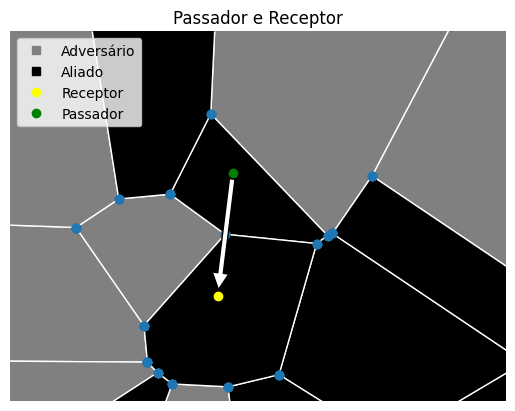

In [42]:
receives = -1
passes = -1
for i in range(22):
    if row[f'{i}_player_id'] == row['target_player']:
        receives = i
    if row[f'{i}_player_id'] == row['passer_player']:
        passes = i

passe_x = [points[passes, 0], points[receives, 0]]
passe_y = [points[passes, 1], points[receives, 1]]

fig, ax = plt.subplots()

for i,region in enumerate(polygons):
  plot_polygon(region, ax=ax, facecolor='k' if i > 10 else 'gray', linewidth=1,edgecolor='w')

ax.plot([], [], 's', color='gray', label='Adversário')
ax.plot([], [], 's', color='k', label='Aliado')

plt.plot(points[receives, 0], points[receives, 1], 'o', color='yellow', label='Receptor')
plt.plot(points[passes, 0], points[passes, 1], 'o', color='green', label='Passador')

plt.annotate('', xy=(passe_x[-1], passe_y[-1]), xytext=(passe_x[0], passe_y[0]),
             arrowprops=dict(facecolor='white', shrink=0.05))

plt.title('Passador e Receptor')

plt.axis('off')
plt.xlim(20, 60)
plt.ylim(35, 68)

# Add the legend
ax.legend(loc='upper left')

plt.show()


### Angulo alpha

In [90]:
def feature_4(row, points, polygons,ax):
  # Função para estender uma linha
  def calcular_angulo(A, B, C, D):
    # Vetores
    AB = (B[0] - A[0], B[1] - A[1])
    CD = (D[0] - C[0], D[1] - C[1])
    
    # Produto escalar
    produto_escalar = AB[0] * CD[0] + AB[1] * CD[1]
    
    # Magnitudes dos vetores
    magnitude_AB = math.sqrt(AB[0]**2 + AB[1]**2)
    magnitude_CD = math.sqrt(CD[0]**2 + CD[1]**2)
    
    # Cálculo do ângulo em radianos
    angulo_radianos = math.acos(produto_escalar / (magnitude_AB * magnitude_CD))
    
    # Convertendo para graus
    angulo_graus = math.degrees(angulo_radianos)
    
    return angulo_graus if angulo_graus <= 90 else 180 - angulo_graus
  
  def extend_line(line, distance):
      # Pega os pontos da linha
      coords = list(line.coords)

      # Calcular o vetor de direção para o início e fim
      start_direction = np.array(coords[1]) - np.array(coords[0])
      end_direction = np.array(coords[-1]) - np.array(coords[-2])

      # Normalizar os vetores
      start_direction /= np.linalg.norm(start_direction)
      end_direction /= np.linalg.norm(end_direction)

      # Calcular os novos pontos
      new_start = np.array(coords[0]) - start_direction * distance
      new_end = np.array(coords[-1]) + end_direction * distance

      # Criar uma nova LineString com os pontos estendidos
      new_coords = [tuple(new_start)] + coords + [tuple(new_end)]
      extended_line = LineString(new_coords)

      return extended_line
  # Pegar poligono do receptor
  receives = -1
  passes = -1
  for i in range(22):
    if row[f'{i}_player_id'] == row['target_player']:
      receives = i
    if row[f'{i}_player_id'] == row['passer_player']:
      passes = i

  passe_x = [points[passes,0], points[receives,0]]
  passe_y = [points[passes,1], points[receives,1]]
  linha = LineString([[passe_x[0],passe_y[0]], [passe_x[1],passe_y[1]]])
  receiver_area = polygons[receives]
  alpha = 0
  pontos = []
  for point in receiver_area.exterior.coords[:-1]:
    #criar a linha
    linha = LineString([[passe_x[0], passe_y[0]], [point[0],point[1]]])
    #extender a linha
    linha_ext = extend_line(linha, 1000)
    if receiver_area.touches(linha_ext):
      angle = calcular_angulo([passe_x[0],passe_y[0]], [passe_x[1],passe_y[1]], [passe_x[0],passe_y[0]], [point[0],point[1]])
      #print(angle)
      alpha += angle
      pontos.append(point)
      plot_line(linha, linewidth=2, color='b',ax=ax)
  return alpha,pontos

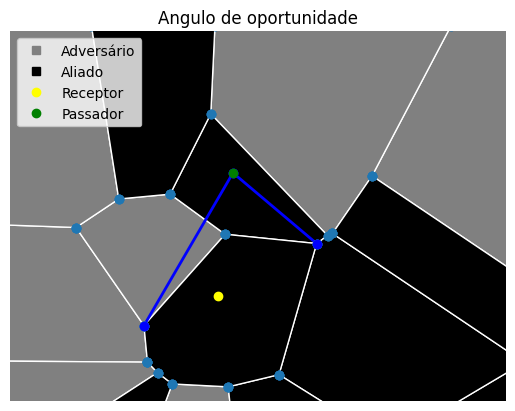

In [95]:
receives = -1
passes = -1
for i in range(22):
    if row[f'{i}_player_id'] == row['target_player']:
        receives = i
    if row[f'{i}_player_id'] == row['passer_player']:
        passes = i

passe_x = [points[passes, 0], points[receives, 0]]
passe_y = [points[passes, 1], points[receives, 1]]

fig, ax = plt.subplots()

for i,region in enumerate(polygons):
  plot_polygon(region, ax=ax, facecolor='k' if i > 10 else 'gray', linewidth=1,edgecolor='w')

ax.plot([], [], 's', color='gray', label='Adversário')
ax.plot([], [], 's', color='k', label='Aliado')


plt.title('Angulo de oportunidade')

plt.axis('off')
plt.xlim(20, 60)
plt.ylim(35, 68)

# Add the legend


feature_4(row, points, polygons,ax)
plt.plot(points[receives, 0], points[receives, 1], 'o', color='yellow', label='Receptor')
plt.plot(points[passes, 0], points[passes, 1], 'o', color='green', label='Passador')
ax.legend(loc='upper left')
plt.show()

### Features 5 a 8

In [45]:
def features_5to8(row, polygons, player_category, operation):
    def PointInPolygon(point, polygon):
        point = Point(point)
        poly = Polygon(polygon)
        return poly.contains(point)

    def FindIntersection(player_coords, opponent_coords, opponent_voronoi):
        line = LineString([player_coords, opponent_coords])
        if opponent_voronoi != [] and line.intersects(opponent_voronoi):
            return line.intersection(opponent_voronoi)
        return None
        
    def Distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    player_number = 0
    player = {'player_id': 0, 'player_number': 0, 'opponents_players_numbers': []}
    for i in range(22):
        if row[f'{i}_player_id'] == row[player_category]:
            player_number = i
            opponents = []
        if (int(player_number) < 11): 
            opponents = [str(i) for i in range(11, 22)]
        else:
            opponents = [str(i) for i in range(11)]
        player_id = row.loc[f'{player_number}_player_id']
        player = {'player_id': player_id, 'player_number': player_number, 'opponents_players_numbers': opponents}

    coords = []
    for region in polygons:
        points_x, points_y = region.exterior.coords.xy
        x = list(points_x)
        y = list(points_y)
        coords.append((x, y))

    opponents_voronoi = {}
    for opponent in player['opponents_players_numbers']:
        opponents_voronoi[int(opponent)] = []
    for coord in coords:
        x, y = coord
        curr_poly = []
        for i in range(len(x)):
            curr_poly.append((x[i], y[i]))
        for opponent in player['opponents_players_numbers']:
            if (PointInPolygon(points[int(opponent)], curr_poly)):
                opponents_voronoi[int(opponent)] = curr_poly
                break

    borders = []
    for opponent in player['opponents_players_numbers']:
        player_coords = (points[int(player['player_number']),0], points[int(player['player_number']),1])
        opponent_coords = (points[int(opponent),0], points[int(opponent),1])
        opponent_voronoi = opponents_voronoi[int(opponent)]
        intersections = FindIntersection(player_coords, opponent_coords, Polygon(opponent_voronoi))
        if intersections:
            x_coords, y_coords = intersections.xy
            borders.append((x_coords[0], y_coords[0]))

    distances = []
    for border in borders:
        distances.append(Distance(player_coords, border))

    if operation == 0:
        return np.mean(distances)
    elif operation == 1:
        return np.min(distances)

In [46]:
print(features_5to8(row, polygons, 'target_player', 0))
print(features_5to8(row, polygons, 'passer_player', 0))
print(features_5to8(row, polygons, 'passer_player', 1))
print(features_5to8(row, polygons, 'target_player', 1))

13.998912915804882
18.472244292796297
2.0951983796290037
2.96644909782723


### Feature 9

In [47]:
receives = -1
passes = -1
for i in range(22):
  if row[f'{i}_player_id'] == row['target_player']:
    receives = i
  if row[f'{i}_player_id'] == row['passer_player']:
    passes = i

In [48]:
def feature_9(row, points, polygons):
  _, pontos = feature_4(row, points, polygons)
  point_passer = points[passes]
  point_receiver = points[receives]

  #criar um triangulo com o jogador passador e os pontos
  triangulo = Polygon([tuple(point_passer)] + pontos)
  adversarios = []
  aliados = []

  if passes > 10:
    for i in range(0,11):
      adversarios.append(polygons[i])
    for i in range(11,22):
      aliados.append(polygons[i])
  else:
    for i in range(11,22):
      adversarios.append(polygons[i])
    for i in range(0,11):
      aliados.append(polygons[i])

  area_aliada = 0
  area_adversario = 0

  for adversario in adversarios:
    plot_polygon(adversario, facecolor='k', linewidth=1, edgecolor='w')
    intersection = triangulo.intersection(adversario)
    if intersection.geom_type == 'LineString':
      #plot_line(intersection, linewidth=1, color='r')
      break
    if not intersection.is_empty and (intersection.geom_type =='Polygon'):
      # print(intersection.area)
      area_adversario += intersection.area
      plot_polygon(intersection, facecolor='r', alpha=0.8, linewidth=1, edgecolor='w')

  for aliado in aliados:
    intersection = triangulo.intersection(aliado)
    plot_polygon(aliado, facecolor='k', linewidth=1, edgecolor='w')
    if not intersection.is_empty and (intersection.geom_type == 'Polygon'):
      #print(intersection.area)
      area_aliada += intersection.area
      plot_polygon(intersection, facecolor='b', alpha=0.8, linewidth=1, edgecolor='w')

    plt.xlim(20, 60)
    plt.ylim(35, 68)

  plt.plot([], [], 's', color='red', label='Adversário')
  plt.plot([], [], 's', color='blue', label='Aliado')
  plot_polygon(triangulo, linewidth=1)
  plot_points(Point(point_passer), color='green', label='Passador')
  plot_points(Point(point_receiver), color='yellow', label='Receptor')
  plt.grid(False)
  plt.axis('off')
  plt.title('Área de regiões adversárias / amigas na faixa de alpha')
  plt.legend(loc='upper left')
  plt.show()
  return area_adversario / (area_adversario + area_aliada)


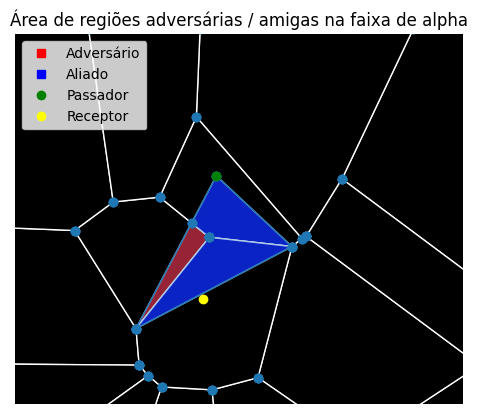

0.15499106215910619

In [49]:
feature_9(row, points, polygons)

In [50]:
def feature_10(points, polygons, passes, receives):
  """
  Calcula a razão entre a area triangulo da bola que é coberta por adversarios e a area total do poligono
  Parameters:
  points: array de pontos
  polygons: array de poligonos
  passes: indice do passador
  receiver: indice do receptor
  """
  def reduce_line_proportionally(line, proportion):
      if proportion < 0 or proportion > 1:
          raise ValueError("Proportion must be between 0 and 1")

      # Pega os pontos da linha
      coords = list(line.coords)

      # Calcula o comprimento total da linha
      line_length = line.length

      # Calcula a distância a ser reduzida em cada extremidade
      reduction_distance = line_length * proportion / 2

      # Calcular o vetor de direção para o início e fim
      start_direction = np.array(coords[1]) - np.array(coords[0])
      end_direction = np.array(coords[-1]) - np.array(coords[-2])

      # Normalizar os vetores
      start_direction /= np.linalg.norm(start_direction)
      end_direction /= np.linalg.norm(end_direction)

      # Calcular os novos pontos
      new_start = np.array(coords[0]) + start_direction * reduction_distance
      new_end = np.array(coords[-1]) - end_direction * reduction_distance

      # Criar uma nova LineString com os pontos reduzidos
      new_coords = [tuple(new_start)] + coords[1:-1] + [tuple(new_end)]
      reduced_line = LineString(new_coords)
      print(reduced_line.length)
      print(line.length)

      return reduced_line

  _, pontos = feature_4(row, points, polygons)
  point_passer = points[passes]
  point_receiver = points[receives]
  pontos_original = pontos
  lado1 = LineString([ponto for ponto in pontos if ponto[0] != point_passer[0] and ponto[1] != point_passer[1]])
  lado1 = reduce_line_proportionally(lado1, 0.7)
  pontos = list(lado1.coords)

  #criar um triangulo com o jogador passador e os pontos
  triangulo = Polygon([tuple(point_passer)] + pontos)
  plot_polygon(triangulo, facecolor='gray', linewidth=1)
  adversarios = []
  aliados = []

  if passes > 10:
    for i in range(0,11):
      adversarios.append(polygons[i])
    for i in range(11,22):
      aliados.append(polygons[i])
  else:
    for i in range(11,22):
      adversarios.append(polygons[i])
    for i in range(0,11):
      aliados.append(polygons[i])

  area_aliada = 0
  area_adversario = 0

  for adversario in adversarios:
    plot_polygon(adversario, facecolor='k', linewidth=1)
    intersection = triangulo.intersection(adversario)
    if intersection.geom_type == 'LineString':
      plot_line(intersection, linewidth=1, color='r')
      break
    if not intersection.is_empty and (intersection.geom_type =='Polygon'):
      # print(intersection.area)
      area_adversario += intersection.area
      plot_polygon(intersection, facecolor='r', alpha=0.5, linewidth=1)

  for aliado in aliados:
    intersection = triangulo.intersection(aliado)
    plot_polygon(aliado, facecolor='k', linewidth=1)
    if not intersection.is_empty and (intersection.geom_type == 'Polygon'):
      #print(intersection.area)
      area_aliada += intersection.area
      plot_polygon(intersection, facecolor='b', alpha=0.5, linewidth=1)
  plt.xlim(20, 60)
  plt.ylim(35, 68)
  plot_polygon(Polygon([tuple(point_passer)] + pontos_original), alpha=0.4, linewidth=1, label='Triângulo original')
  plot_polygon(triangulo, linewidth=1, label='Triângulo reduzido')
  plot_points(Point(point_passer), color='green', label='Passador')
  plot_points(Point(point_receiver), color='yellow', label='Receptor')
  plt.grid(False)
  plt.axis('off')
  plt.title('Área de regiões adversárias / amigas na faixa de alpha reduzido')
  plt.legend(loc='upper left')
  plt.show()
  return area_adversario / (area_adversario + area_aliada)


4.719766413847339
15.732554712824472


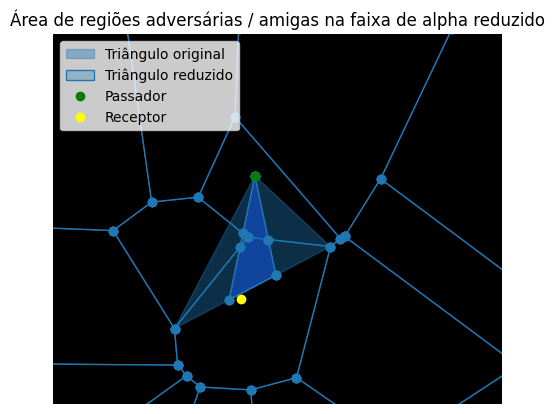

0.01503930980971115

In [51]:

feature_10(points, polygons, passes, receives)

In [52]:
def cria_features(row):
  cols_x = [str(i)+"_x" for i in range(22)]
  cols_y = [str(i)+"_y" for i in range(22)]

  points = np.column_stack([(row[cols_x] + 52.5).values, (row[cols_y] + 34).values])

  vor = Voronoi(points)
  bounding_box = [-0.5, 105.5, -0.5, 68.5]
  x = voronoi(points, bounding_box)
  polygons = []
  for region in x.filtered_regions:
    polygons.append(Polygon(x.vertices[region]))

  areas = []
  controle = [-1]*len(x.filtered_points)
  for i, player in enumerate(x.filtered_points):
    for j,region in enumerate(polygons):
      player = Point(player)
      if controle[i] == -1 and region.contains(player):
        aux = Polygon(region)
        areas += [aux.area]
        controle[i] = j
        break

  aux = [polygons[i] for i in controle]
  polygons = aux

  f1,f2 = feature_1_2(row, areas)
  f3 = feature_3(row, points, polygons)
  f4, pontos = feature_4(row, points, polygons)
  f5 = features_5to8(row, polygons, 'target_player', 0)
  f6 = features_5to8(row, polygons, 'passer_player', 0)
  f7 = features_5to8(row, polygons, 'passer_player', 1)
  f8 = features_5to8(row, polygons, 'target_player', 1)
  f9 = feature_9(row, points, polygons)

  return f1, f2, f3, f4, f5, f6, f7, f8, f9

In [53]:
from tqdm import tqdm

# aux = []

columns = ['instance_index',
           'receiver_polygon_area',
           'transmitter_polygon_area',
           'adversary_domain_pass_count',
           'alpha_angle',
           'avg_distance_receiver_adversary_boundaries',
           'avg_distance_transmitter_adversary_boundaries',
           'min_distance_transmitter_adversary_boundaries',
           'min_distance_receiver_adversary_boundaries',
           'adversary_friend_area_ratio']

# for instance_index in tqdm(range(len(interception_events[:10]))):
#   row = interception_events.loc[instance_index, :]
#   try:
#     f1, f2, f3, f4, f5, f6, f7, f8, f9 = cria_features(row)
#     aux += [[instance_index,f1, f2, f3, f4, f5, f6, f7, f8, f9]]
#   except Exception as e:
#     ...
#     #print(instance_index, e)


In [54]:
#df.to_csv('features.csv')

In [55]:
#df.to_csv('features.csv')

In [56]:
df = pd.read_csv('features.csv', index_col=0)
df

,instance_index,receiver_polygon_area,transmitter_polygon_area,adversary_domain_pass_count,alpha_angle,avg_distance_receiver_adversary_boundaries,avg_distance_transmitter_adversary_boundaries,min_distance_transmitter_adversary_boundaries,min_distance_receiver_adversary_boundaries,adversary_friend_area_ratio,adversary_friend_area_ratio_reduced
0,0,63.387090,242.767714,0,48.156930,14.131091,17.587928,0.000000,6.140610,0.024118,0.000449
1,1,328.830275,408.025340,0,58.704612,15.767308,18.423632,1.156407,0.000000,0.018736,0.000000
2,2,254.831618,70.313232,2,17.323893,20.418469,22.508726,3.036266,0.000000,0.544893,0.481678
3,3,184.194074,150.526507,0,65.250709,29.217714,30.671222,6.660653,5.542375,0.047695,0.000000
4,4,129.126380,81.344942,1,43.009257,18.395356,27.761639,3.688869,1.138226,0.301728,0.073614
...,...,...,...,...,...,...,...,...,...,...,...
19027,19641,133.429255,67.917380,1,47.485117,16.238429,26.325304,0.000000,1.521276,0.280977,0.180987
19028,19642,39.492882,38.329336,1,66.250561,14.867957,29.208292,0.000000,3.520009,0.213316,0.092141
19029,19643,39.618935,290.455836,2,55.133690,18.439042,15.691319,2.950423,0.000000,0.182282,0.144665
19030,19644,155.677638,44.348470,2,44.230966,33.815027,17.524179,0.000000,0.000000,0.989693,0.990967


In [57]:
df[df['instance_index'] == instance_index]

,instance_index,receiver_polygon_area,transmitter_polygon_area,adversary_domain_pass_count,alpha_angle,avg_distance_receiver_adversary_boundaries,avg_distance_transmitter_adversary_boundaries,min_distance_transmitter_adversary_boundaries,min_distance_receiver_adversary_boundaries,adversary_friend_area_ratio,adversary_friend_area_ratio_reduced
2716,2771,69.058826,132.647396,0,74.674187,7.288585,19.164181,2.969955,0.0,0.154991,0.015039


In [58]:
teste = interception_events.iloc[instance_index,:]


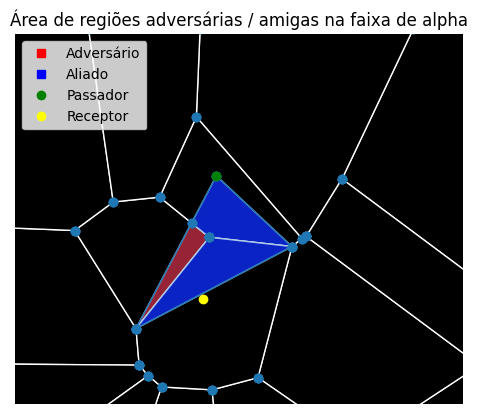

(69.05882602140217,
 132.6473957955909,
 0,
 74.67418714634529,
 13.998912915804882,
 18.472244292796297,
 2.0951983796290037,
 2.96644909782723,
 0.15499106215910619)

In [59]:
cria_features(teste)

In [60]:
# get alpha angles greater than 4
df[df['alpha_angle'] > 4]

,instance_index,receiver_polygon_area,transmitter_polygon_area,adversary_domain_pass_count,alpha_angle,avg_distance_receiver_adversary_boundaries,avg_distance_transmitter_adversary_boundaries,min_distance_transmitter_adversary_boundaries,min_distance_receiver_adversary_boundaries,adversary_friend_area_ratio,adversary_friend_area_ratio_reduced
0,0,63.387090,242.767714,0,48.156930,14.131091,17.587928,0.000000,6.140610,0.024118,0.000449
1,1,328.830275,408.025340,0,58.704612,15.767308,18.423632,1.156407,0.000000,0.018736,0.000000
2,2,254.831618,70.313232,2,17.323893,20.418469,22.508726,3.036266,0.000000,0.544893,0.481678
3,3,184.194074,150.526507,0,65.250709,29.217714,30.671222,6.660653,5.542375,0.047695,0.000000
4,4,129.126380,81.344942,1,43.009257,18.395356,27.761639,3.688869,1.138226,0.301728,0.073614
...,...,...,...,...,...,...,...,...,...,...,...
19027,19641,133.429255,67.917380,1,47.485117,16.238429,26.325304,0.000000,1.521276,0.280977,0.180987
19028,19642,39.492882,38.329336,1,66.250561,14.867957,29.208292,0.000000,3.520009,0.213316,0.092141
19029,19643,39.618935,290.455836,2,55.133690,18.439042,15.691319,2.950423,0.000000,0.182282,0.144665
19030,19644,155.677638,44.348470,2,44.230966,33.815027,17.524179,0.000000,0.000000,0.989693,0.990967
